# Kappa Model in Omega

This notebook explores the application of Omega and Gillespie sampling to a Rule-based model of Kinase phosphorylation: https://github.com/djinnome/kappa-counterfactuals.

In [1]:
## Load Packages
using Omega
using StatsBase
using Random
using Plots
using Distributions
using PyCall
using DataStructures

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1192
┌ Warning: Module JSON with build ID 28048663874804 is missing from the cache.
│ This may mean JSON [682c06a0-de6a-54ab-a142-c8b1cf79cde6] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:947
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1192
rec_backtrace at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\stackwalk.c:94
record_backtrace at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\task.c:246
jl_throw at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\task.c:577
jl_bounds_error_ints at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64

## Load SBML #1

In [2]:
te = pyimport("tellurium")
sbml = te.loadSBMLModel("kappa_resimulation_figure2.sbml")
ant = te.sbmlToAntimony("kappa_resimulation_figure2.sbml")
print(ant)

// Created by libAntimony v2.12.0.3
model *kappa_resimulation_figure2()

  // Compartments and Species:
  compartment default;
  substanceOnly species __s0 in default, __s1 in default, __s2 in default;
  substanceOnly species __s3 in default, __s4 in default, __s5 in default;
  substanceOnly species __s6 in default, __s7 in default;

  // Assignment Rules:
  __obs0 := __s0 + __s3 + __s5;
  __obs1 := __s1 + __s3 + __s4;

  // Reactions:
  r0: __s0 => __s2; __s0*mod_rate_slow;
  r1: __s0 + __s1 -> __s3; __s0*__s1*on_rate - __s3*off_rate_fast;
  r2: __s3 => __s4; __s3*mod_rate_slow;
  r3: __s1 + __s2 -> __s4; __s1*__s2*on_rate - __s4*off_rate_slow;
  r4: __s3 => __s5; __s3*mod_rate;
  r5: __s5 => __s6; __s5*mod_rate_slow;
  r6: __s5 -> __s0 + __s7; -(__s0*__s7*on_rate) + __s5*off_rate_fast;
  r7: __s4 => __s6; __s4*mod_rate;
  r8: __s2 + __s7 -> __s6; __s2*__s7*on_rate - __s6*off_rate_slow;

  // Species initializations:
  __s0 = K_0;
  __s1 = S_0;
  __s2 = 0;
  __s3 = 0;
  __s4 = 0;
  __

### Build Model

In [3]:
function get_parameters(sbml_file_path)
        
    """
    Function to extract model parameters from sbml. Returns dictionary with 
    a transition matrix, species list, and rates list.
    """
    ## Load SBML
    sbml = te.loadSBMLModel(sbml_file_path)

    ## Transition Matrix
    transition = sbml.getFullStoichiometryMatrix()
    transition = transpose(transition)
    
    ## Extract Species
    species_ids = sbml.getFloatingSpeciesIds()
    species_starting_vals = sbml.getFloatingSpeciesAmounts()
    species = Dict(species_ids .=> species_starting_vals)
    
    ## Extract Rates
    rates = Dict(sbml.getGlobalParameterIds() .=> sbml.getGlobalParameterValues())
    
    return Dict("transition" => transition, "species" => species, "rates" => rates)
    
end

get_parameters (generic function with 1 method)

In [4]:
model_params = get_parameters("kappa_resimulation_figure2.sbml")
t = vcat(model_params["transition"], [0 0 0 0 0 0 0 0])
species = model_params["species"]
rates = model_params["rates"]
print()

In [77]:
species["__s1"] = 1
species["__s0"] = 1
species

Dict{String,Float64} with 8 entries:
  "__s1" => 1.0
  "__s4" => 0.0
  "__s0" => 1.0
  "__s2" => 0.0
  "__s6" => 0.0
  "__s7" => 0.0
  "__s5" => 0.0
  "__s3" => 0.0

In [78]:
function full_sim(rng, n, theta)
    
    """
    Function to sample from given hazard values. Takes previous species values and outputs the se3ected hazard and if that hazard was negative.
    """

    ecology = OrderedDict("__s0" => S0_list[n](rng), "__s1" => S1_list[n](rng), "__s2" => S2_list[n](rng), 
        "__s3" => S3_list[n](rng), "__s4" => S4_list[n](rng),"__s5" => S5_list[n](rng), "__s6" => S6_list[n](rng), 
        "__s7" => S7_list[n](rng), "time" => time_list[n](rng))

    haz = OrderedDict(sbml.getReactionIds() .=> [
        ecology["__s0"]*theta["mod_rate_slow"],
        ecology["__s0"]*ecology["__s1"]*theta["on_rate"] - ecology["__s3"]*theta["off_rate_fast"],
        ecology["__s3"]*theta["mod_rate_slow"],
        ecology["__s1"]*ecology["__s2"]*theta["on_rate"] - ecology["__s4"]*theta["off_rate_slow"],
        ecology["__s3"]*theta["mod_rate"],
        ecology["__s5"]*theta["mod_rate_slow"],
        -(ecology["__s0"]*ecology["__s7"]*theta["on_rate"]) + ecology["__s5"]*theta["off_rate_fast"],
        ecology["__s4"]*theta["mod_rate"],
        ecology["__s2"]*ecology["__s7"]*theta["on_rate"] - ecology["__s6"]*theta["off_rate_slow"]]
        )
    
    t = Any[]
    for (key, value) in haz
        if value < 0
            haz[key] = 0 - value
            push!(t, 1)
        else 
            push!(t, 0)
        end
    end
    
    ## Get values from hazard dictionary
    vals = collect(values(haz))
    sum_vals = sum(vals)
    ## Calculate probabilities
    prob_vals = vals/sum_vals
    ## Sample
    hazard_result = categorical(rng, prob_vals)
    
    ## Track species values
    push!(S0_vals, ecology["__s0"])
    push!(S1_vals, ecology["__s1"])
    push!(S2_vals, ecology["__s2"])
    push!(S3_vals, ecology["__s3"])
    push!(S4_vals, ecology["__s4"])
    push!(S5_vals, ecology["__s5"])
    push!(S6_vals, ecology["__s6"])
    push!(S7_vals, ecology["__s7"])
    push!(time_vals, ecology["time"])
    push!(reaction_samples, hazard_result)
    
    return hazard_result, t[hazard_result], sum_vals
    
end

function reaction_gen(rng, n)
    
    t_idx = ecology_list[n](rng)
    t = t_idx[1]
    return t
end

function S0_gen(rng, n, transition)
    
    """
    Individual function for each species. Need seperate random variables to apply interventions and conditionals.
    """
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample,:])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S0_val = S0_vals[n] + update_val[1]
    S0_val = max(0, S0_val)
    return S0_val
end

function S1_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample,:])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S1_val = S1_vals[n] + update_val[2]
    S1_val = max(0, S1_val)
    return S1_val
end
function S2_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample,:])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S2_val = S2_vals[n] + update_val[3]
    S2_val = max(0, S2_val)
    return S2_val
end
function S3_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample,:])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S3_val = S3_vals[n] + update_val[4]
    S3_val = max(0, S3_val)
    return S3_val
end
function S4_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample,:])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S4_val = S4_vals[n] + update_val[5]
    S4_val = max(0, S4_val)
    return S4_val
end
function S5_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample,:])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S5_val = S5_vals[n] + update_val[6]
    S5_val = max(0, S5_val)
    return S5_val
end
function S6_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample,:])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S6_val = S6_vals[n] + update_val[7]
    S6_val = max(0, S6_val)
    return S6_val
end
function S7_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample,:])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    S7_val = S7_vals[n] + update_val[8]
    S7_val = max(0, S7_val)
    return S7_val
end
function time_gen(rng, n)
    t_idx = ecology_list[n](rng)
    haz_sum = t_idx[3]
    time_val = time_vals[n] + exponential(rng, haz_sum)
    return time_val
end

time_gen (generic function with 1 method)

In [89]:
function omega_simulation(theta, transition, starting_species, N_steps, seed, intervention = false)
    
    ## Initialize lists to hold random variables and species values
    global S0_list = Any[]; global S1_list = Any[]; global S2_list = Any[]
    global S3_list = Any[]; global S4_list = Any[]; global S5_list = Any[]
    global S6_list = Any[]; global S7_list = Any[]; global ecology_list = Any[]
    global time_list = Any[]; global reaction_list = Any[]
    
    global S0_vals = []; global S1_vals = []; global S2_vals = []
    global S3_vals = []; global S4_vals = []; global S5_vals = []
    global S6_vals = []; global S7_vals = []; global time_vals = []
    global reaction_samples = []
    
    ## Insert starting species values
    #insert!(S0_list, 1, normal(species["__s0"], .00001))
    insert!(S0_list, 1, uniform([starting_species["__s0"]]))
    insert!(S1_list, 1, uniform([starting_species["__s1"]]))
    insert!(S2_list, 1, uniform([starting_species["__s2"]]))
    insert!(S3_list, 1, uniform([starting_species["__s3"]]))
    insert!(S4_list, 1, uniform([starting_species["__s4"]]))
    insert!(S5_list, 1, uniform([starting_species["__s5"]]))
    insert!(S6_list, 1, uniform([starting_species["__s6"]]))
    insert!(S7_list, 1, uniform([starting_species["__s7"]]))
    insert!(time_list, 1, uniform([0]))
    
    ## Create random variables for each step
    for f in 2:N_steps
        last = f - 1
        push!(ecology_list, ciid(full_sim, last, theta))
        push!(reaction_list, ciid(reaction_gen, last))
        push!(S0_list, ciid(S0_gen, last, transition))
        push!(S1_list, ciid(S1_gen, last, transition))
        push!(S2_list, ciid(S2_gen, last, transition))
        push!(S3_list, ciid(S3_gen, last, transition))
        push!(S4_list, ciid(S4_gen, last, transition))
        push!(S5_list, ciid(S5_gen, last, transition))
        push!(S6_list, ciid(S6_gen, last, transition))
        push!(S7_list, ciid(S7_gen, last, transition))
        push!(time_list, ciid(time_gen, last))
    end
    
    ## Insert intervention if needed
    tracker = Dict("__s0" => S0_list, "__s1" => S1_list, "__s2" => S2_list, 
        "__s3" => S3_list, "__s4" => S4_list, "__s5" => S5_list, "__s6" => S6_list, 
        "__s7" => S7_list, "reaction" => reaction_list)
    
    if intervention != false
        intervene_list = tracker[intervention[1]]
        intervene_list[intervention[2]] = replace(intervene_list[intervention[2]], intervene_list[intervention[2]] => intervention[3])
    end
    
    ## Sample
    Random.seed!(seed)
    samples = rand(Tuple(reaction_list), 1, alg = RejectionSample)

#     output = OrderedDict("S0" => S0_vals[1:N_steps-1], "S1" => S1_vals[1:N_steps-1], "S2" => S2_vals[1:N_steps-1], 
#         "S3" => S3_vals[1:N_steps-1], "S4" => S4_vals[1:N_steps-1], "S5" => S5_vals[1:N_steps-1], "S6" => S6_vals[1:N_steps-1], 
#         "S7" => S7_vals[1:N_steps-1], "time" => time_vals[1:N_steps-1], "reactions" => reaction_samples[1:N_steps-1])
#     return output
    return samples, time_vals[1:N_steps-1]
    
end

omega_simulation (generic function with 2 methods)

### Run Simulation

In [90]:
simple_sim = omega_simulation(rates, t, species, 2000, 02)
print()

#### Reaction/Events List

$PK_1: K_u => K_p$

$PK_2: K_u.S_u => K_p.S_u$

$PK_3: K_u.S_p => K_p.S_p$

$p_1: K_u.S_u => K_u.S_p$

$p_2: K_p.S_u => K_p.S_p$

$bind-unbind: K_u + S_u => K_u.S_u$

$unbind-bind: K_u.S_p => K_u + S_p$

$bind-unbind-slow_1: K_p + S_u => K_p.S_u$

$bind-unbind-slow_2: K_p + S_p => K_p.S_p$

$No Reaction$

Phosphorylation of substrate (p) can only occur with a bound Kinase. Phosphorylation of the Kinase can occur when it is both bound and unbound to the substrate. We have an array of 4 binding and unbinding events to bind and seperate the proteins at different states.

This SBML originally starts with 1000 unphosphorylated Kinase and 100 unphosphorylated substrates. To more closely look at the relationship between individual proteins, I have updated this to one protein of each type.

In [92]:
map_dict = OrderedDict(1 => "pK1", 2 => "b + u", 3 => "pK2", 4 => "b + u_slow1",
                        5 => "p1", 6 => "pK3", 7 => "u + b", 8 => "p2", 9 => "b + u_slow2", 
                        10 => "no_reaction")
simple_labels = [map_dict[i] for i in simple_sim[1][1]]
print()

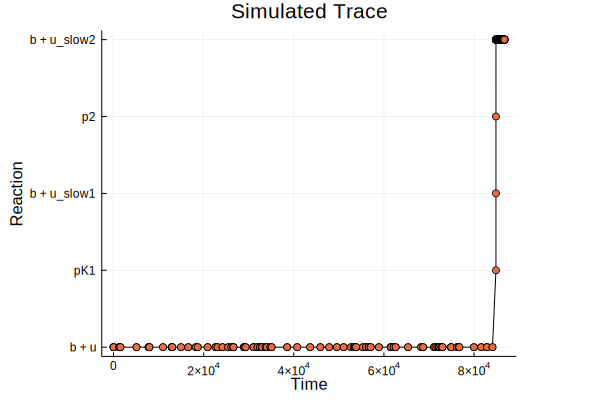

In [112]:
plot(simple_sim[2], simple_labels,
        linecolor = ["black"], label = false)
plot!(simple_sim[2], simple_labels,
        title = "Simulated Trace",
        xlabel = "Time",
        ylabel = "Reaction",
        label = false,
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

Reaction 1, 3, 6 => "pk"

In [93]:
findall(x -> x=="pK1", simple_labels)

1-element Array{Int64,1}:
 165

In [94]:
findall(x -> x=="pK2", simple_labels)

0-element Array{Int64,1}

In [95]:
findall(x -> x=="pK3", simple_labels)

0-element Array{Int64,1}

We only see one case of pK which was phosphorylation of an unbound Kinase. We can plot the reactions as below.

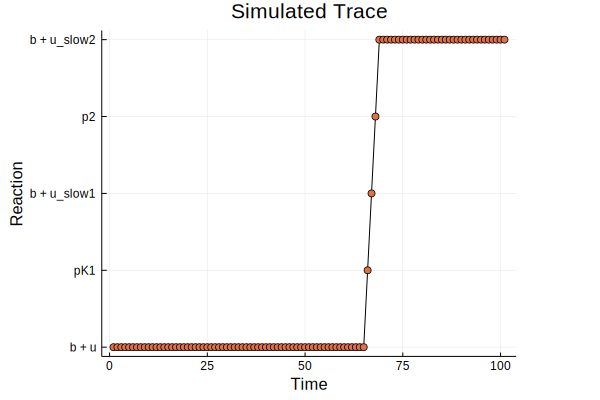

In [100]:
plot(simple_labels[100:200],
        linecolor = ["black"], label = false)
plot!(simple_labels[100:200],
        title = "Simulated Trace",
        xlabel = "Time",
        ylabel = "Reaction",
        label = false,
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

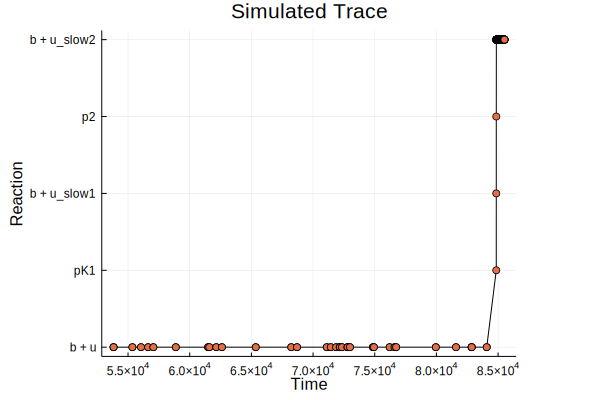

In [98]:
plot(simple_sim[2][100:800], simple_labels[100:800],
        linecolor = ["black"], label = false)
plot!(simple_sim[2][100:800], simple_labels[100:800],
        title = "Simulated Trace",
        xlabel = "Time",
        ylabel = "Reaction",
        label = false,
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

The two unphosphorylated proteins continually bind and unbind until pK occurs, phosphorylating the Kinase. We then see a binding of the Kinase-P and Substrate-U, followed by a phosphorylation of the substrate. Finally, the two phosphorylated proteins go through binding and unbinding in a new "equilibrium".

From this we can see the train of events starts with the phosphorylation of the Kinase (pK). Given the trace above, what would have happened if pK had not happeend? We can answer this counterfactual using an intervention and setting the state to 𝑁𝑜𝑅𝑒𝑎𝑐𝑡𝑖𝑜𝑛 at the time pK occured.

In [101]:
intervention_sim = omega_simulation(rates, t, species, 2000, 02, ("reaction", 165, 10))
print()

In [102]:
intervention_labels = [map_dict[i] for i in intervention_sim[1][1]]
print()

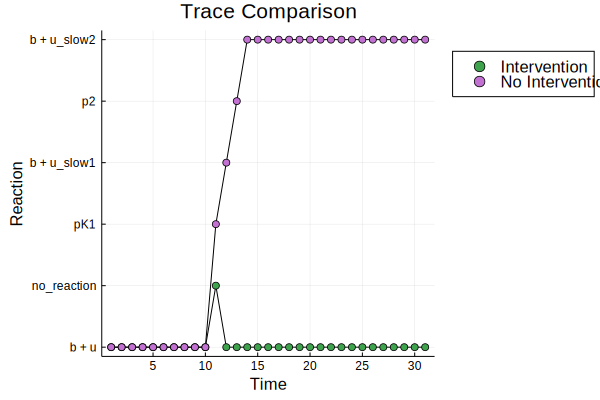

In [103]:
plot(hcat(intervention_labels[155:185], simple_labels[155:185]),
        linecolor = ["black"], label = false)
plot!(hcat(intervention_labels[155:185], simple_labels[155:185]),
        title = "Trace Comparison",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Intervention" "No Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

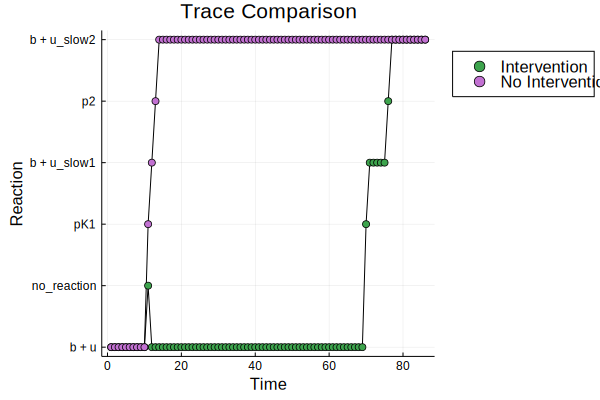

In [104]:
plot(hcat(intervention_labels[155:240], simple_labels[155:240]),
        linecolor = ["black"], label = false)
plot!(hcat(intervention_labels[155:240], simple_labels[155:240]),
        title = "Trace Comparison",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Intervention" "No Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

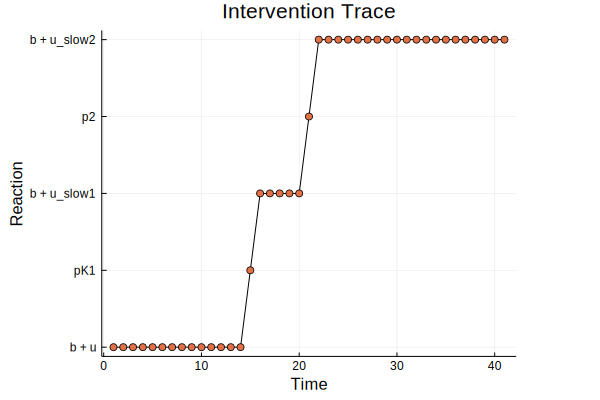

In [105]:
plot(intervention_labels[210:250],
        linecolor = ["black"], label = false)
plot!(intervention_labels[210:250],
        title = "Intervention Trace",
        xlabel = "Time",
        ylabel = "Reaction",
        label = false,
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

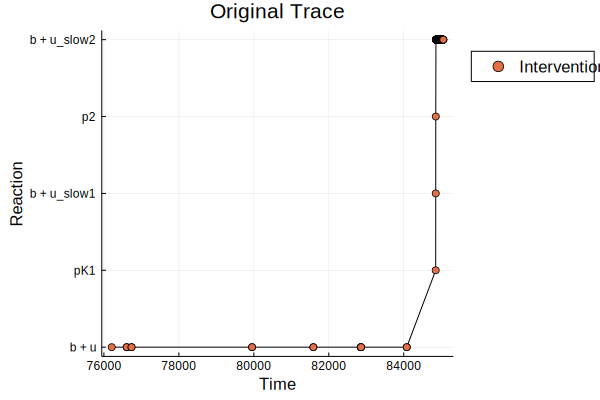

In [111]:
plot(simple_sim[2][150:350], simple_labels[150:350],
        linecolor = ["black"], label = false)
plot!(simple_sim[2][150:350], simple_labels[150:350],
        title = "Original Trace",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Intervention" "No Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

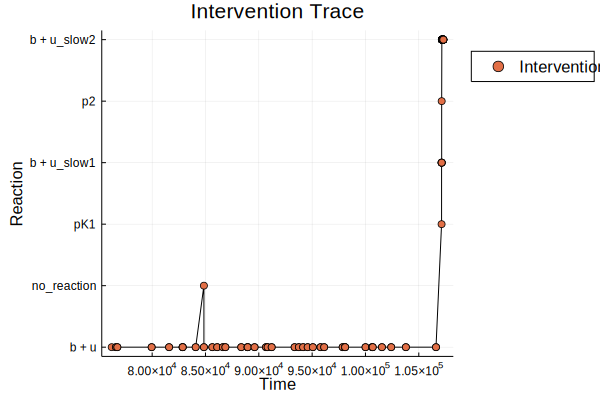

In [110]:
plot(intervention_sim[2][150:350], intervention_labels[150:350],
        linecolor = ["black"], label = false)
plot!(intervention_sim[2][150:350], intervention_labels[150:350],
        title = "Intervention Trace",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Intervention" "No Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

## SBML #2 - Kappa_resimulationmodel_sbml_KaDE

In [113]:
sbml = te.loadSBMLModel("Kappa_resimulationmodel_sbml_KaDE.sbml")
ant = te.sbmlToAntimony("Kappa_resimulationmodel_sbml_KaDE.sbml")
print(ant)

// Created by libAntimony v2.12.0.3
model *KaDe_output_()

  // Compartments and Species:
  compartment default;
  species s1 in default, s2 in default, s3 in default, s4 in default, s5 in default;
  species s6 in default, s7 in default, s8 in default;

  // Reactions:
  re1: s3 => s5; mod_rate_slow*s3;
  re2: s3 => s1 + s2; off_rate_fast*s3;
  re3: s3 => s8; mod_rate*s3;
  re4: s8 => s6; mod_rate_slow*s8;
  re5: s8 => s1 + s7; off_rate_fast*s8;
  re6: s1 + s7 => s8; (1/VA)*(s7*s1);
  re7: s4 + s7 => s6; (1/VA)*(s7*s4);
  re8: s6 => s4 + s7; off_rate_slow*s6;
  re9: s5 => s2 + s4; off_rate_slow*s5;
  re10: s5 => s6; mod_rate*s5;
  re11: s2 + s4 => s5; (1/VA)*(s2*s4);
  re12: s1 => s4; mod_rate_slow*s1;
  re13: s1 + s2 => s3; (1/VA)*(s2*s1);

  // Species initializations:
  s1 = 1/default;
  s1 has substance_per_volume;
  s2 = 1/default;
  s2 has substance_per_volume;
  s3 = 0;
  s3 has substance_per_volume;
  s4 = 0;
  s4 has substance_per_volume;
  s5 = 0;
  s5 has substance_per_volum

### Build Model

In [114]:
model_params = get_parameters("Kappa_resimulationmodel_sbml_KaDE.sbml")
t = vcat(model_params["transition"], [0 0 0 0 0 0 0 0])
species = model_params["species"]
rates = model_params["rates"]
print()

In [115]:
species

Dict{String,Float64} with 8 entries:
  "s1" => 1.0
  "s8" => 0.0
  "s5" => 0.0
  "s6" => 0.0
  "s7" => 0.0
  "s2" => 1.0
  "s4" => 0.0
  "s3" => 0.0

In [116]:
function full_sim(rng, n, theta)
    
    """
    Function to sample from given hazard values. Takes previous species values and outputs the se3ected hazard and if that hazard was negative.
    """

    ecology = OrderedDict("s1" => S1_list[n](rng), "s2" => S2_list[n](rng), "s3" => S3_list[n](rng), 
        "s4" => S4_list[n](rng), "s5" => S5_list[n](rng),"s6" => S6_list[n](rng), "s7" => S7_list[n](rng), 
        "s8" => S8_list[n](rng), "time" => time_list[n](rng))

    haz = OrderedDict(sbml.getReactionIds() .=> [
        ecology["s3"]*theta["mod_rate_slow"],
        ecology["s3"]*theta["off_rate_fast"],
        ecology["s3"]*theta["mod_rate"],
        ecology["s8"]*theta["mod_rate_slow"],
        ecology["s8"]*theta["off_rate_fast"],
        (1/theta["VA"])*(ecology["s7"]*ecology["s1"]),
        (1/theta["VA"])*(ecology["s7"]*ecology["s4"]),
        ecology["s6"]*theta["off_rate_slow"],
        ecology["s5"]*theta["off_rate_slow"],
        ecology["s5"]*theta["mod_rate"],
        (1/theta["VA"])*(ecology["s2"]*ecology["s4"]),
        ecology["s1"]*theta["mod_rate_slow"],
        (1/theta["VA"])*(ecology["s2"]*ecology["s1"])]
        )
    
    t = Any[]
    for (key, value) in haz
        if value < 0
            haz[key] = 0 - value
            push!(t, 1)
        else 
            push!(t, 0)
        end
    end
    
    ## Get values from hazard dictionary
    vals = collect(values(haz))
    sum_vals = sum(vals)
    ## Calculate probabilities
    prob_vals = vals/sum_vals
    ## Sample
    hazard_result = categorical(rng, prob_vals)
    
    ## Track species values
    push!(S1_vals, ecology["s1"])
    push!(S2_vals, ecology["s2"])
    push!(S3_vals, ecology["s3"])
    push!(S4_vals, ecology["s4"])
    push!(S5_vals, ecology["s5"])
    push!(S6_vals, ecology["s6"])
    push!(S7_vals, ecology["s7"])
    push!(S8_vals, ecology["s8"])
    push!(time_vals, ecology["time"])
    push!(reaction_samples, hazard_result)
    
    return hazard_result, t[hazard_result], sum_vals
    
end

function reaction_gen(rng, n)
    
    t_idx = ecology_list[n](rng)
    t = t_idx[1]
    return t
end

function S1_gen(rng, n, transition)
    
    """
    Individual function for each species. Need seperate random variables to apply interventions and conditionals.
    """
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample,:])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S1_val = S1_vals[n] + update_val[1]
    S1_val = max(0, S1_val)
    return S1_val
end

function S2_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample,:])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S2_val = S2_vals[n] + update_val[2]
    S2_val = max(0, S2_val)
    return S2_val
end
function S3_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample,:])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S3_val = S3_vals[n] + update_val[3]
    S3_val = max(0, S3_val)
    return S3_val
end
function S4_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample,:])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S4_val = S4_vals[n] + update_val[4]
    S4_val = max(0, S4_val)
    return S4_val
end
function S5_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample,:])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S5_val = S5_vals[n] + update_val[5]
    S5_val = max(0, S5_val)
    return S5_val
end
function S6_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample,:])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S6_val = S6_vals[n] + update_val[6]
    S6_val = max(0, S6_val)
    return S6_val
end
function S7_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample,:])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S7_val = S7_vals[n] + update_val[7]
    S7_val = max(0, S7_val)
    return S7_val
end
function S8_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample,:])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    S8_val = S8_vals[n] + update_val[8]
    S8_val = max(0, S8_val)
    return S8_val
end
function time_gen(rng, n)
    t_idx = ecology_list[n](rng)
    haz_sum = t_idx[3]
    time_val = time_vals[n] + exponential(rng, haz_sum)
    return time_val
end

time_gen (generic function with 1 method)

In [124]:
function omega_simulation(theta, transition, starting_species, N_steps, seed, intervention = false)
    
    ## Initialize lists to hold random variables and species values
    global S1_list = Any[]; global S2_list = Any[]; global S3_list = Any[]
    global S4_list = Any[]; global S5_list = Any[]; global S6_list = Any[]
    global S7_list = Any[]; global S8_list = Any[]; global ecology_list = Any[]
    global time_list = Any[]; global reaction_list = Any[]
    
    global S1_vals = []; global S2_vals = []; global S3_vals = []
    global S4_vals = []; global S5_vals = []; global S6_vals = []
    global S7_vals = []; global S8_vals = []; global time_vals = []
    global reaction_samples = []
    
    ## Insert starting species values
    #insert!(S0_list, 1, normal(species["__s0"], .00001))
    insert!(S1_list, 1, uniform([starting_species["s1"]]))
    insert!(S2_list, 1, uniform([starting_species["s2"]]))
    insert!(S3_list, 1, uniform([starting_species["s3"]]))
    insert!(S4_list, 1, uniform([starting_species["s4"]]))
    insert!(S5_list, 1, uniform([starting_species["s5"]]))
    insert!(S6_list, 1, uniform([starting_species["s6"]]))
    insert!(S7_list, 1, uniform([starting_species["s7"]]))
    insert!(S8_list, 1, uniform([starting_species["s8"]]))
    insert!(time_list, 1, uniform([0]))
    
    ## Create random variables for each step
    for f in 2:N_steps
        last = f - 1
        push!(ecology_list, ciid(full_sim, last, theta))
        push!(reaction_list, ciid(reaction_gen, last))
        push!(S1_list, ciid(S1_gen, last, transition))
        push!(S2_list, ciid(S2_gen, last, transition))
        push!(S3_list, ciid(S3_gen, last, transition))
        push!(S4_list, ciid(S4_gen, last, transition))
        push!(S5_list, ciid(S5_gen, last, transition))
        push!(S6_list, ciid(S6_gen, last, transition))
        push!(S7_list, ciid(S7_gen, last, transition))
        push!(S8_list, ciid(S8_gen, last, transition))
        push!(time_list, ciid(time_gen, last))
    end
    
    ## Insert intervention if needed
    tracker = Dict("s1" => S1_list, "s2" => S2_list, "s3" => S3_list, 
        "s4" => S4_list, "s5" => S5_list, "s6" => S6_list, "s7" => S7_list, 
        "s8" => S8_list, "reaction" => reaction_list)
    
    if intervention != false
        intervene_list = tracker[intervention[1]]
        intervene_list[intervention[2]] = replace(intervene_list[intervention[2]], intervene_list[intervention[2]] => intervention[3])
    end
    
    ## Sample
    Random.seed!(seed)
    samples = rand(Tuple(reaction_list), 1, alg = RejectionSample)

#     output = OrderedDict("S0" => S0_vals[1:N_steps-1], "S1" => S1_vals[1:N_steps-1], "S2" => S2_vals[1:N_steps-1], 
#         "S3" => S3_vals[1:N_steps-1], "S4" => S4_vals[1:N_steps-1], "S5" => S5_vals[1:N_steps-1], "S6" => S6_vals[1:N_steps-1], 
#         "S7" => S7_vals[1:N_steps-1], "time" => time_vals[1:N_steps-1], "reactions" => reaction_samples[1:N_steps-1])
#     return output
    return samples, time_vals[1:N_steps-1]
    
end

omega_simulation (generic function with 2 methods)

### Run Simulation

In [125]:
simple_sim = omega_simulation(rates, t, species, 2000, 02)
print()

$pK_1: K_u.S_u => K_p.S_u$

$pK_2: K_u.S_p => K_p.S_p$

$pK_3: K_u => K_p$

$p_1: K_u.S_u => K_u.S_p$

$p_2: K_p.S_u => K_p.S_p$

$u_1: K_u.S_u => K_u + S_u$

$u_2: K_u.S_p => K_u + S_p$

$u^*_1: K_p.S_p => K_p + S_p$

$u^*_2: K_p.S_u => K_p + S_u$

$b_1: K_u + S_p => K_u.S_p$

$b_2: K_p + S_p => K_p.S_p$

$b_3: K_p + S_u => K_p.S_u$

$b_4: K_u + S_u => K_u.S_u$

$NoReaction$

In [126]:
map_dict = OrderedDict(1 => "pK1", 2 => "u1", 3 => "p1", 4 => "pK2",
    5 => "u2", 6 => "b1", 7 => "b2", 8 => "u*1", 9 => "u*2", 
    10 => "p2", 11 => "b3", 12 => "pK3", 13 => "b4", 14 => "NoReaction")
simple_labels = [map_dict[i] for i in simple_sim[1][1]]
print()

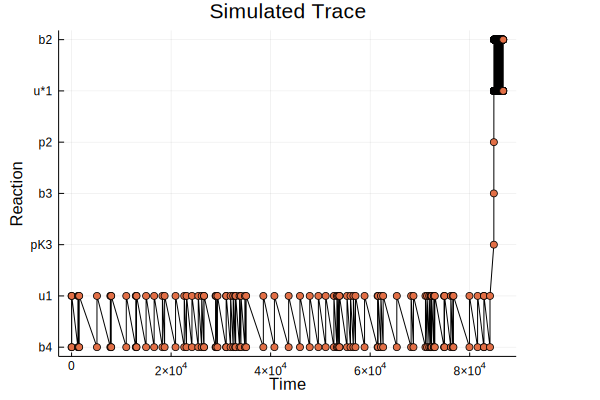

In [127]:
plot(simple_sim[2], simple_labels,
        linecolor = ["black"], label = false)
plot!(simple_sim[2], simple_labels,
        title = "Simulated Trace",
        xlabel = "Time",
        ylabel = "Reaction",
        label = false,
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

Reaction 1, 3, 6 => "pk"

In [128]:
findall(x -> x=="pK1", simple_labels)

0-element Array{Int64,1}

In [129]:
findall(x -> x=="pK2", simple_labels)

0-element Array{Int64,1}

In [130]:
findall(x -> x=="pK3", simple_labels)

1-element Array{Int64,1}:
 165

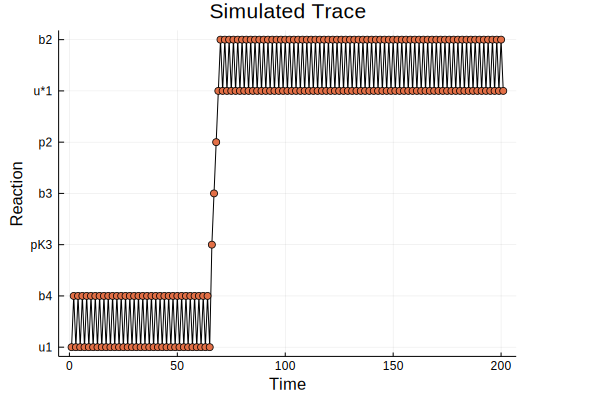

In [131]:
plot(simple_labels[100:300],
        linecolor = ["black"], label = false)
plot!(simple_labels[100:300],
        title = "Simulated Trace",
        xlabel = "Time",
        ylabel = "Reaction",
        label = false,
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

In [132]:
intervention_sim = omega_simulation(rates, t, species, 2000, 02, ("reaction", 165, 14))
print()

In [133]:
intervention_labels = [map_dict[i] for i in intervention_sim[1][1]]
print()

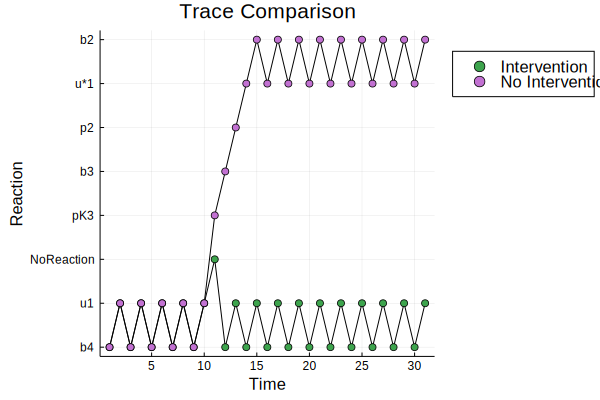

In [35]:
plot(hcat(intervention_labels[155:185], simple_labels[155:185]),
        linecolor = ["black"], label = false)
plot!(hcat(intervention_labels[155:185], simple_labels[155:185]),
        title = "Trace Comparison",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Intervention" "No Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

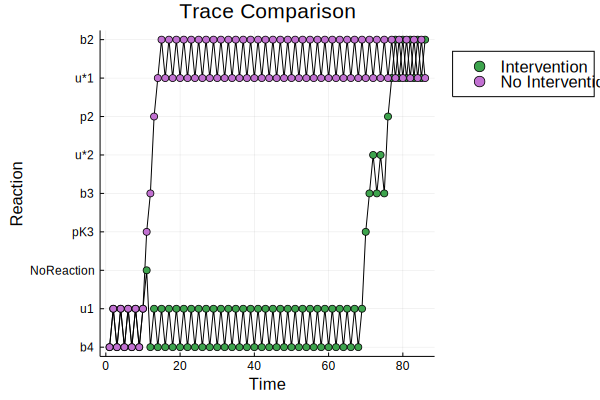

In [36]:
plot(hcat(intervention_labels[155:240], simple_labels[155:240]),
        linecolor = ["black"], label = false)
plot!(hcat(intervention_labels[155:240], simple_labels[155:240]),
        title = "Trace Comparison",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Intervention" "No Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

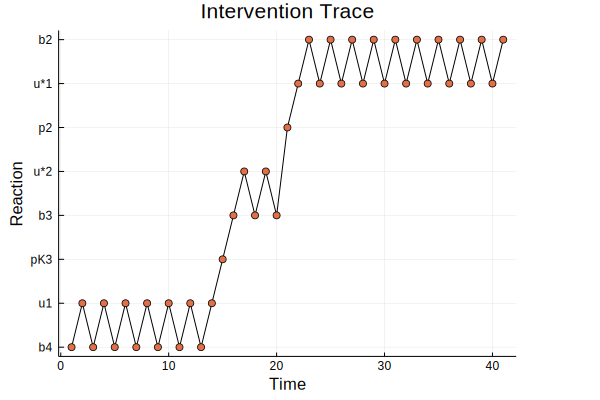

In [37]:
plot(intervention_labels[210:250],
        linecolor = ["black"], label = false)
plot!(intervention_labels[210:250],
        title = "Intervention Trace",
        xlabel = "Time",
        ylabel = "Reaction",
        label = false,
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

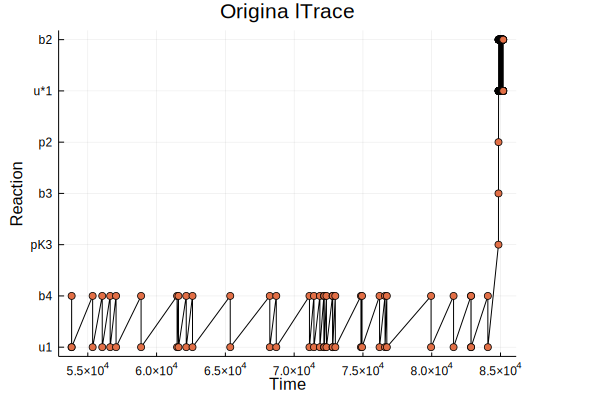

In [136]:
plot(simple_sim[2][100:500], simple_labels[100:500],
        linecolor = ["black"], label = false)
plot!(simple_sim[2][100:500], simple_labels[100:500],
        title = "Origina lTrace",
        xlabel = "Time",
        ylabel = "Reaction",
        label = false,
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

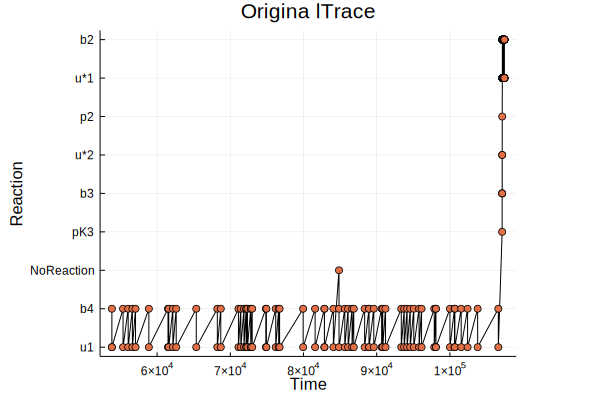

In [137]:
plot(intervention_sim[2][100:500], intervention_labels[100:500],
        linecolor = ["black"], label = false)
plot!(intervention_sim[2][100:500], intervention_labels[100:500],
        title = "Origina lTrace",
        xlabel = "Time",
        ylabel = "Reaction",
        label = false,
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

#### Set intervention to real reaction

In [138]:
intervention_sim = omega_simulation(rates, t, species, 2000, 02, ("reaction", 165, 13))
intervention_labels = [map_dict[i] for i in intervention_sim[1][1]]
print()

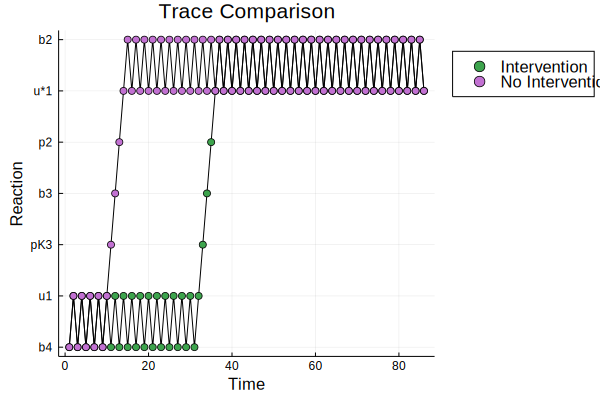

In [139]:
plot(hcat(intervention_labels[155:240], simple_labels[155:240]),
        linecolor = ["black"], label = false)
plot!(hcat(intervention_labels[155:240], simple_labels[155:240]),
        title = "Trace Comparison",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Intervention" "No Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

### Can we find a different type of trace?

In [140]:
simple_sim = omega_simulation(rates, t, species, 2000, 66)
simple_labels = [map_dict[i] for i in simple_sim[1][1]]
print()

In [141]:
findall(x -> x=="p1", simple_labels)

1-element Array{Int64,1}:
 68

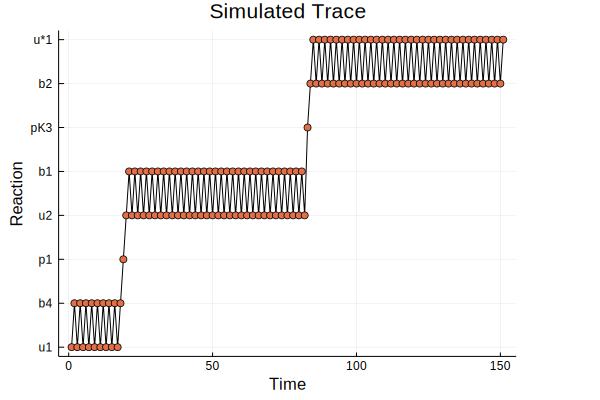

In [142]:
plot(simple_labels[50:200],
        linecolor = ["black"], label = false)
plot!(simple_labels[50:200],
        title = "Simulated Trace",
        xlabel = "Time",
        ylabel = "Reaction",
        label = false,
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)

In [143]:
intervention_sim = omega_simulation(rates, t, species, 2000, 66, ("reaction", 68, 14))
intervention_labels = [map_dict[i] for i in intervention_sim[1][1]]
print()

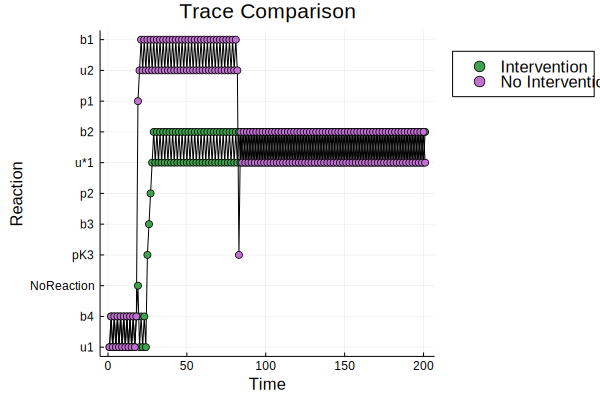

In [144]:
plot(hcat(intervention_labels[50:250], simple_labels[50:250]),
        linecolor = ["black"], label = false)
plot!(hcat(intervention_labels[50:250], simple_labels[50:250]),
        title = "Trace Comparison",
        xlabel = "Time",
        ylabel = "Reaction",
        label = ["Intervention" "No Intervention"],
        lw = 1.25,
        legend = :outertopright, 
        seriestype = :scatter)